# Water Quality Notebook

Notebook for calculation of Total Suspended Matter(TSM) in water bodies. Uses inputs of Landsat-4, Landsat-5, Landsat-7, Landsat-8 and Sentinel-2. 

TSM stands for "Total Suspended Matter" - also called TSS which stands for "Total Suspended Solids". It is the dry-weight of particles suspended (not dissolved) in a body of water. It is a proxy of water quality.

This notebook is based from work by ceos-seo at the following link, 
https://github.com/ceos-seo/data_cube_notebooks/blob/master/TSM_Demo_Notebook.ipynb, where the TSM equation originates from. 

Academic papers include Lymburner, L., Botha, E., Hestir, E., Anstee, J., Sagar, S., Dekker, A. and Malthus, T., 2016. Landsat 8: providing continuity and increased precision for measuring multi-decadal time series of total suspended matter. Remote Sensing of Environment, 185, pp.108-118.

This paper demonstrates continuity between the Landsat sensors for TSM assessment. Calibration for S2 use has not been carried out. 



### Import Required Modules

In [1]:
# The dtip fork of datacude_utilities includes some updated requirements which we need for the notebook to run on the updated dask cluster
!pip install git+https://github.com/dtip/datacube-utilities.git#egg=datacube_utilities
#!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

### Import required modules

In [2]:
%matplotlib inline
import datacube

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from datacube.storage import masking
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.interactive_maps import display_map
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.dc_water_quality import tsm
from datacube_utilities.dc_water_classifier import wofs_classify
import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

assert(xr.__version__ == "0.15.0")
assert(dask.__version__ == "2.12.0")

client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

Client Scheduler: tcp://dask-scheduler.dask.svc.cluster.local:8786 Dashboard: http://dask-scheduler.dask.svc.cluster.local:8787/status,Cluster Workers: 3 Cores: 24 Memory: 101.19 GB


## Initialise

In [3]:
dc = datacube.Datacube(app='ls8-fcscene')

## Set up datacube query.
This includes options for crs, a groupby for overlapping datasets, a time range, and a spatial extent. 

In [4]:
#set baseline start and end of period
baseline_start_date = '2019-2-1'
baseline_end_date = '2019-12-30'

#resolution - have this as a variable which can be changed. 
res = (30)

# options include "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4", "SENTINEL_2"
#won't run for S2 - out of memory error.
platform = "LANDSAT_8"
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"

#this is a constant across FIJI so maybe put it not as a variable but built into query. 
output_projection = "EPSG:3460"
crs = "EPSG:3460"

## Translate inputs

In [5]:
#time_range
#format dates
from datetime import datetime
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period
baseline_time_period = createDate(baseline_start_date, baseline_end_date)


In [6]:
#create resolution
resolution = (-res, res)

In [7]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [8]:
# format area
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [9]:
#display_map(latitude = lat_extents, longitude = lon_extents)

In [10]:
# crs's for input parameters 
inProj  = Proj("+init=EPSG:4326")
#this is hard coded can it be related to crs variable above. 
outProj = Proj("+init=EPSG:3460")

In [11]:
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)

In [12]:
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)

In [13]:
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)

In [14]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [15]:
product, measurement, water_product = create_product_measurement(platform)

## Load Data 

In [16]:
query = {
    'longitude': lon_range,
    'latitude': lat_range,
    'output_crs': output_projection,
    'resolution': resolution,
    'time': baseline_time_period,
    'dask_chunks': dask_chunks,
    'crs': crs
}

In [17]:
ds = dc.load(
    platform = platform,
    product = product,
    measurements = measurement,
    **query
)
ds

<xarray.Dataset>
Dimensions:   (time: 14, x: 210, y: 259)
Coordinates:
  * time      (time) datetime64[ns] 2019-02-14T22:06:22 ... 2019-09-10T22:06:52
  * y         (y) float64 3.934e+06 3.934e+06 3.934e+06 ... 3.927e+06 3.927e+06
  * x         (x) float64 2.024e+06 2.024e+06 2.024e+06 ... 2.031e+06 2.031e+06
Data variables:
    green     (time, y, x) int16 dask.array<chunksize=(1, 259, 210), meta=np.ndarray>
    red       (time, y, x) int16 dask.array<chunksize=(1, 259, 210), meta=np.ndarray>
    blue      (time, y, x) int16 dask.array<chunksize=(1, 259, 210), meta=np.ndarray>
    nir       (time, y, x) int16 dask.array<chunksize=(1, 259, 210), meta=np.ndarray>
    swir1     (time, y, x) int16 dask.array<chunksize=(1, 259, 210), meta=np.ndarray>
    swir2     (time, y, x) int16 dask.array<chunksize=(1, 259, 210), meta=np.ndarray>
    pixel_qa  (time, y, x) uint16 dask.array<chunksize=(1, 259, 210), meta=np.ndarray>
Attributes:
    crs:      EPSG:3460

In [18]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

if is_dataset_empty(ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")


## Mask cloud

In [19]:
def look_up_clean(platform, ds):
    if platform  in ["SENTINEL_2"]:
        good_quality = (
            (ds.scene_classification != 0) & # mask out NO_DATA
            (ds.scene_classification != 1) & # mask out SATURATED_OR_DEFECTIVE
            (ds.scene_classification != 2) & # mask out DARK_AREA_PIXELS
            (ds.scene_classification != 3) & # mask out CLOUD_SHADOWS
            (ds.scene_classification != 8) & # mask out CLOUD_MEDIUM_PROBABILITY
            (ds.scene_classification != 9) & # mask out CLOUD_HIGH_PROBABILITY
            (ds.scene_classification != 10)&  # mask out THIN_CIRRUS
            (ds.scene_classification != 11)  # mask out SNOW
        )
    elif platform in ["LANDSAT_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130)  |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [20]:
good_quality = look_up_clean(platform, ds)

In [21]:
ds_clear = dask.delayed(ds.where(good_quality))

## Create and apply land masks
For Landsat these are pre-created. For Sentinel-2 these need to be created.

In [22]:
#when S2 mask is ready - can remove the if statement. 
if platform in ["LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4"]:   
    water_scenes = dc.load(product=water_product,
              measurements = ["water_classification"],
               **query)
    #change clouds to no data value
    water_classes = water_scenes.where(water_scenes >= 0)
elif platform in ["SENTINEL_2"]:
    water_classes = dask.delayed(wofs_classify)(ds, clean_mask=good_quality.values, no_data = np.nan , x_coord='x', y_coord = "y")
    water_classes = water_classes.rename({'wofs': 'water_classification'})

In [23]:
#set land to no_data
water_dataset = dask.delayed(water_classes.where(water_classes > 0))

In [24]:
#mask clear by water mask
ds_clear_land = dask.delayed(ds_clear.where(water_dataset.water_classification.values > 0))

In [25]:
#create tsm
tsm_dataset = dask.delayed(tsm)(ds_clear_land)

In [26]:
%%time
tsm_dataset_comp= tsm_dataset.compute()

CPU times: user 295 ms, sys: 27.8 ms, total: 323 ms
Wall time: 21.5 s


## Calculate mean, maximum and minimum TSM for the time period and export as GeoTiffs.

In [27]:
%%time
mean_tsm = tsm_dataset_comp.mean(dim=['time'])

CPU times: user 29.4 ms, sys: 3.64 ms, total: 33 ms
Wall time: 31.5 ms


/opt/conda/envs/cubeenv/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


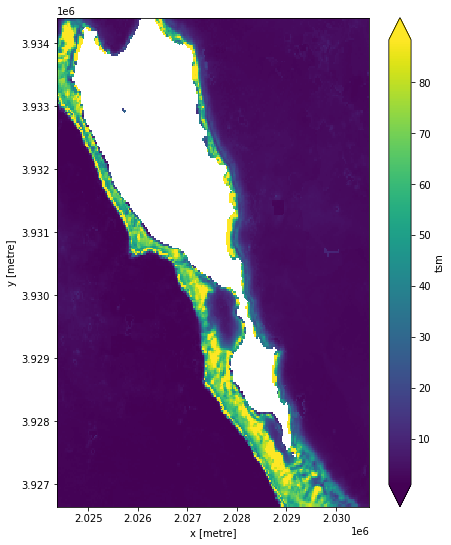

In [28]:
fig = plt.figure(figsize=(7, 9))
mean_tsm.tsm.plot(robust=True)

## plot max tsm

/opt/conda/envs/cubeenv/lib/python3.6/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


CPU times: user 64.5 ms, sys: 58 µs, total: 64.5 ms
Wall time: 63.5 ms


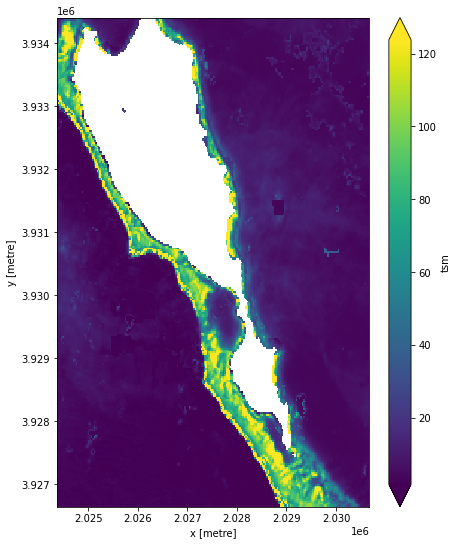

In [29]:
%%time
max_tsm = tsm_dataset_comp.max(dim=['time'])
fig = plt.figure(figsize=(7, 9))
max_tsm.tsm.plot(robust=True)

CPU times: user 65.8 ms, sys: 219 µs, total: 66 ms
Wall time: 64.5 ms


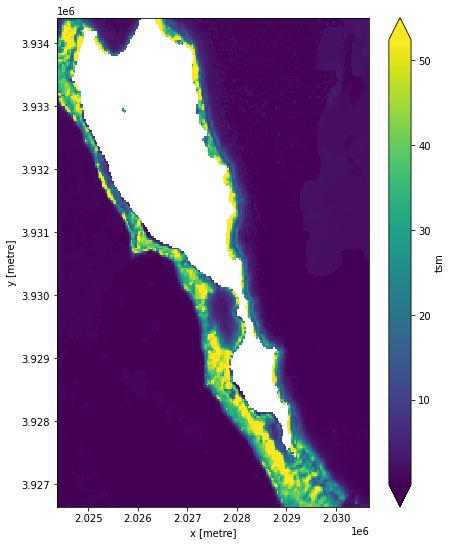

In [30]:
%%time
min_tsm = tsm_dataset_comp.min(dim=['time'])
fig = plt.figure(figsize=(7, 9))
min_tsm.tsm.plot(robust=True)

## Exports

In [31]:
write_geotiff_from_xr('mean_tsm.tiff', mean_tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')
write_geotiff_from_xr('min_tsm.tiff', min_tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')
write_geotiff_from_xr('max_tsm.tiff', max_tsm, crs=output_projection, x_coord = 'x', y_coord = 'y')

---